<a href="https://colab.research.google.com/github/jbsdoki/Bellman_Ford_Forex/blob/main/CS182_Special_Participation_E_Berry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dive: Understanding Optimizer Effects on Weight Matrices

This notebook demonstrates how different optimization algorithms (Adam, Shampoo, Soap, and Muon) transform their weight matrices at a fundamental level.
- Evolution of singular values and matrix conditioning
- Gradient flow and preconditioning effects
- Convergence behavior on a simple dataset

In [14]:
# Install necessary libraries
!pip -q install numpy matplotlib scipy

## Optimizer Deep Dive

### What Makes Optimizers Different?

All optimizers update weights using: **W_new = W_old - lr × update**

The key difference is **how they precondition the gradient** to compute the update:

---

### 1. **Adam (Adaptive Moment Estimation)**

**Core Idea:** Adaptive per-parameter learning rates using exponential moving averages.

**Update Rule:**
```
m_t = β₁·m_{t-1} + (1-β₁)·g_t          (first moment: momentum)
v_t = β₂·v_{t-1} + (1-β₂)·g_t²         (second moment: variance)
update = lr · m̂_t / (√v̂_t + ε)         (bias-corrected adaptive step)
```

**Key Properties:**
- Diagonal preconditioning: each parameter has its own learning rate
- Memory: O(2*Number_Parameters) for storing m and v
- Works well with sparse gradients
- Default choice for most problems

---

### 2. **Shampoo (Scalable Higher-order Adaptive Methods for Preconditioning Optimization)**

**Core Idea:** Kronecker-factored second-order preconditioning for structured adaptivity.

**Update Rule (for matrix W ∈ ℝ^{m×n}):**
```
L_t = L_{t-1} + G_t·G_t^T              (left preconditioner, m×m)
R_t = R_{t-1} + G_t^T·G_t              (right preconditioner, n×n)
update = lr · L_t^{-1/4}·G_t·R_t^{-1/4}
```

**Key Properties:**
- Uses **Kronecker factorization**: approximates full (mn×mn) Hessian with two smaller matrices
- Matrix power L^{-1/4} computed via eigendecomposition
- Memory: O(m² + n²) instead of O((mn)²)
- Better conditioning than diagonal methods
- Update frequency: typically every 10-100 steps (amortizes cost)

**Why Kronecker Factorization Works:**
- Exploits structure: (A⊗B)^s = A^s ⊗ B^s
- Captures row-column correlations in weight matrices
- Provably never worse than full-matrix AdaGrad (up to rank constants)

---

### 3. **SOAP (Shampoo with Adam in the Preconditioner's eigenbasis)**

**Core Idea:** Run Adam in the rotated space defined by Shampoo's eigenbasis.

**Update Rule:**
```
Compute Shampoo preconditioner eigenbases: U, V
Rotate gradient: G_rotated = U^T·G_t·V
Apply Adam in rotated space on G_rotated
Rotate back to original space
```

**Key Properties:**
- Combines strengths: Shampoo's geometry + Adam's robustness
- Infrequent eigen-updates (cheap moment tracking between updates)
- Memory efficient: low-rank approximations
- Outperforms both Adam and Shampoo in large-batch LLM training
- Fewer hyperparameters than full Shampoo

---

### 4. **Muon (Momentum with Orthogonalized Updates)**

**Core Idea:** Maintain orthogonality of momentum via Newton-Schulz5 iterations.

**Update Rule:**
```
v_t = β·v_{t-1} + g_t                              (momentum accumulation)
v_ortho = NewtonSchulz5(v_t, steps=5)              (orthogonalize)
update = lr · v_ortho

Newton-Schulz5 iteration (coefficients: a=3.4445, b=-4.7750, c=2.0315):
  X = X / ||X||                                     (normalize)
  for i in 1..5:
    A = X·X^T
    X = a·X + (b·A + c·A²)·X                       (5th-order step)
```

**Key Properties:**
- Enforces X^T·X ≈ I (orthogonality constraint)
- 5th-order convergence: error ∝ O(ε⁵) per iteration
- Prevents gradient correlation across update directions
- Maintains better gradient flow in deep networks
- Inspired by geometric optimization and Lie group methods

---

### Why Do Singular Values Matter?

Singular values reveal the **conditioning** and **information capacity** of weight matrices:

| Condition | Singular Values | Impact on Training |
|-----------|----------------|-------------------|
| **Well-conditioned** | Similar magnitudes | Even gradient flow, stable updates |
| **Ill-conditioned** | Wide spread (σ₁ >> σₙ) | Some directions train 1000× faster |
| **Rank deficient** | Many near-zero | Lost representational capacity |

**Good optimizers actively manage conditioning:**
- **Adam:** Adapts per-element, doesn't see correlations
- **Shampoo/SOAP:** Explicitly precondition to balance singular values
- **Muon:** Maintains orthogonality (all σᵢ ≈ 1 in update direction)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.linalg import sqrtm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## Create Simple Dataset

We'll use a small synthetic dataset to clearly see optimizer effects.

In [16]:
def generate_dataset(n_samples=200, input_dim=16):
    """Generate a challenging classification dataset with ill-conditioned features"""
    np.random.seed(42)

    # Create two clusters that are MUCH closer together (harder problem)
    X1 = np.random.randn(n_samples // 2, input_dim) * 1.2 + np.array([0.5] * input_dim)
    X2 = np.random.randn(n_samples // 2, input_dim) * 1.2 + np.array([-0.5] * input_dim)

    # Add strong correlation to create ill-conditioning (harder for optimizers)
    for i in range(1, min(8, input_dim)):
        # First half of features are highly correlated
        X1[:, i] = X1[:, i] * 0.3 + X1[:, 0] * 0.7
        X2[:, i] = X2[:, i] * 0.3 + X2[:, 0] * 0.7

    # Add some non-linear transformations to make it harder
    X1[:, :input_dim//2] = X1[:, :input_dim//2] ** 2
    X2[:, :input_dim//2] = X2[:, :input_dim//2] ** 2

    X = np.vstack([X1, X2])
    y = np.vstack([np.ones((n_samples // 2, 1)), np.zeros((n_samples // 2, 1))])

    # Shuffle
    indices = np.random.permutation(n_samples)
    X = X[indices]
    y = y[indices]

    return X, y

X_train, y_train = generate_dataset()
print(f"Dataset shape: X={X_train.shape}, y={y_train.shape}")
print(f"X range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print("Problem made HARDER: closer clusters, more correlation, non-linear features")

Dataset shape: X=(200, 16), y=(200, 1)
X range: [-4.12, 15.91]
Problem made HARDER: closer clusters, more correlation, non-linear features


## Simple Neural Network Implementation

We'll implement a simple 2-layer network from scratch to have full control and visibility.

In [17]:
class SimpleNetwork:
    """Simple 2-layer neural network for demonstration"""

    def __init__(self, input_dim=16, hidden_dim=20, output_dim=1):
        # Initialize weights with Xavier initialization
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, output_dim))

        # Cache for backprop
        self.cache = {}

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def forward(self, X):
        """Forward pass"""
        self.cache['X'] = X
        self.cache['Z1'] = X @ self.W1 + self.b1
        self.cache['A1'] = self.relu(self.cache['Z1'])
        self.cache['Z2'] = self.cache['A1'] @ self.W2 + self.b2
        self.cache['A2'] = self.sigmoid(self.cache['Z2'])
        return self.cache['A2']

    def compute_loss(self, y_pred, y_true):
        """Binary cross-entropy loss"""
        epsilon = 1e-8
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def backward(self, y_true):
        """Backward pass - compute gradients"""
        m = y_true.shape[0]

        # Output layer gradient
        dZ2 = self.cache['A2'] - y_true
        dW2 = (self.cache['A1'].T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Hidden layer gradient
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.cache['Z1'])
        dW1 = (self.cache['X'].T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        return {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }

    def get_weights(self):
        """Return current weights"""
        return {
            'W1': self.W1.copy(),
            'b1': self.b1.copy(),
            'W2': self.W2.copy(),
            'b2': self.b2.copy()
        }

    def get_singular_values(self):
        """Compute singular values of weight matrices"""
        sv1 = np.linalg.svd(self.W1, compute_uv=False)
        sv2 = np.linalg.svd(self.W2, compute_uv=False)
        return {'W1': sv1, 'W2': sv2}

## Optimizer Implementations

Now we implement Adam, Shampoo, Soap, and Muon optimizers from scratch.

In [18]:
class AdamOptimizer:
    """Adam: Adaptive Moment Estimation"""

    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # First moment
        self.v = {}  # Second moment
        self.t = 0   # Time step

    def update(self, network, grads):
        self.t += 1

        for param_name in ['W1', 'b1', 'W2', 'b2']:
            if param_name not in self.m:
                self.m[param_name] = np.zeros_like(grads[f'd{param_name}'])
                self.v[param_name] = np.zeros_like(grads[f'd{param_name}'])

            # Update biased first moment estimate
            self.m[param_name] = self.beta1 * self.m[param_name] + (1 - self.beta1) * grads[f'd{param_name}']

            # Update biased second moment estimate
            self.v[param_name] = self.beta2 * self.v[param_name] + (1 - self.beta2) * (grads[f'd{param_name}'] ** 2)

            # Compute bias-corrected moments
            m_hat = self.m[param_name] / (1 - self.beta1 ** self.t)
            v_hat = self.v[param_name] / (1 - self.beta2 ** self.t)

            # Update parameters
            update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            setattr(network, param_name, getattr(network, param_name) - update)


class ShampooOptimizer:
    """Shampoo: Second-order optimizer with Kronecker-factored preconditioners"""

    def __init__(self, lr=0.01, epsilon=1e-8, update_freq=10):
        self.lr = lr
        self.epsilon = epsilon
        self.update_freq = update_freq
        self.L = {}  # Left preconditioners
        self.R = {}  # Right preconditioners
        self.t = 0

    def matrix_power(self, matrix, power):
        """Compute matrix^power using eigendecomposition"""
        # Add regularization for numerical stability
        matrix_reg = matrix + self.epsilon * np.eye(matrix.shape[0])
        eigvals, eigvecs = np.linalg.eigh(matrix_reg)
        eigvals = np.maximum(eigvals, self.epsilon)  # Ensure positive
        return eigvecs @ np.diag(eigvals ** power) @ eigvecs.T

    def update(self, network, grads):
        self.t += 1

        for param_name in ['W1', 'W2']:
            grad = grads[f'd{param_name}']

            # Initialize preconditioners
            if param_name not in self.L:
                self.L[param_name] = np.eye(grad.shape[0]) * self.epsilon
                self.R[param_name] = np.eye(grad.shape[1]) * self.epsilon

            # Accumulate second moment statistics
            self.L[param_name] = 0.9 * self.L[param_name] + 0.1 * (grad @ grad.T)
            self.R[param_name] = 0.9 * self.R[param_name] + 0.1 * (grad.T @ grad)

            # Compute preconditioned gradient
            if self.t % self.update_freq == 0:
                L_inv = self.matrix_power(self.L[param_name], -0.25)
                R_inv = self.matrix_power(self.R[param_name], -0.25)
                preconditioned_grad = L_inv @ grad @ R_inv
            else:
                # Use cached preconditioners for efficiency
                preconditioned_grad = grad

            # Update weights
            W = getattr(network, param_name)
            setattr(network, param_name, W - self.lr * preconditioned_grad)

        # Simple updates for biases
        for param_name in ['b1', 'b2']:
            b = getattr(network, param_name)
            setattr(network, param_name, b - self.lr * grads[f'd{param_name}'])


class SoapOptimizer:
    """
    Soap: Simplified second-order optimizer with low-rank approximations.

    Note: This is a demonstration implementation. Production SOAP runs Adam
    in Shampoo's eigenbasis (Vyas et al., 2024).
    """

    def __init__(self, lr=0.01, epsilon=1e-8, rank=5):
        self.lr = lr
        self.epsilon = epsilon
        self.rank = rank  # Low-rank approximation
        self.G = {}  # Gradient accumulator
        self.t = 0

    def low_rank_preconditioner(self, matrix, rank):
        """Compute low-rank approximation of inverse square root"""
        try:
            U, s, Vt = np.linalg.svd(matrix, full_matrices=False)
            s = np.maximum(s, self.epsilon)
            s_inv = 1.0 / np.sqrt(s[:rank])
            return U[:, :rank] @ np.diag(s_inv) @ Vt[:rank, :]
        except:
            return np.eye(matrix.shape[0])

    def update(self, network, grads):
        self.t += 1

        for param_name in ['W1', 'W2']:
            grad = grads[f'd{param_name}']

            # Initialize gradient accumulator
            if param_name not in self.G:
                self.G[param_name] = np.zeros_like(grad)

            # Accumulate gradient information
            self.G[param_name] = 0.9 * self.G[param_name] + 0.1 * grad

            # Apply low-rank preconditioning
            if self.t % 5 == 0:
                G_cov = self.G[param_name].T @ self.G[param_name]
                preconditioner = self.low_rank_preconditioner(G_cov, min(self.rank, min(G_cov.shape)))
                preconditioned_grad = grad @ preconditioner
            else:
                preconditioned_grad = grad

            # Update weights
            W = getattr(network, param_name)
            setattr(network, param_name, W - self.lr * preconditioned_grad)

        # Simple updates for biases
        for param_name in ['b1', 'b2']:
            b = getattr(network, param_name)
            setattr(network, param_name, b - self.lr * grads[f'd{param_name}'])


class MuonOptimizer:
    """Muon: Momentum with orthogonal updates using Newton-Schulz5 algorithm"""

    def __init__(self, lr=0.01, momentum=0.9, ns_steps=5):
        self.lr = lr
        self.momentum = momentum
        self.ns_steps = ns_steps  # Newton-Schulz iteration steps
        self.velocity = {}

    def newtonschulz5(self, G, steps=5, eps=1e-7):
        """
        Newton-Schulz 5th order algorithm for orthogonalization.

        Uses optimized coefficients for 5th order convergence:
        a=3.4445, b=-4.7750, c=2.0315

        The iteration: X_{k+1} = a*X + (b*A + c*A@A)@X where A = X@X^T
        """
        assert G.ndim == 2, "Input must be 2D matrix"

        # Coefficients for 5th order convergence
        a, b, c = (3.4445, -4.7750, 2.0315)

        # Work with float32
        X = G.astype(np.float32).copy()

        # Normalize
        X /= (np.linalg.norm(X) + eps)

        # Handle tall vs wide matrices
        transpose = False
        if G.shape[0] > G.shape[1]:
            X = X.T
            transpose = True

        # Newton-Schulz iterations
        for _ in range(steps):
            A = X @ X.T
            B = b * A + c * (A @ A)
            X = a * X + B @ X

        # Transpose back if needed
        if transpose:
            X = X.T

        return X

    def orthogonalize(self, matrix):
        """Orthogonalize matrix using Newton-Schulz5 algorithm"""
        try:
            # Apply Newton-Schulz5 iterations
            ortho_matrix = self.newtonschulz5(matrix, steps=self.ns_steps)
            return ortho_matrix
        except (np.linalg.LinAlgError, ValueError, AssertionError):
            # Fallback to QR if Newton-Schulz fails
            try:
                Q, R = np.linalg.qr(matrix)
                return Q
            except:
                return matrix

    def update(self, network, grads):
        for param_name in ['W1', 'W2']:
            grad = grads[f'd{param_name}']

            # Initialize velocity
            if param_name not in self.velocity:
                self.velocity[param_name] = np.zeros_like(grad)

            # Update velocity with momentum
            self.velocity[param_name] = self.momentum * self.velocity[param_name] + grad

            # Orthogonalize the update direction
            ortho_update = self.orthogonalize(self.velocity[param_name])

            # Scale back to gradient magnitude
            scale = np.linalg.norm(self.velocity[param_name]) / (np.linalg.norm(ortho_update) + 1e-8)
            ortho_update = ortho_update * scale

            # Update weights
            W = getattr(network, param_name)
            setattr(network, param_name, W - self.lr * ortho_update)

        # Simple momentum updates for biases
        for param_name in ['b1', 'b2']:
            if param_name not in self.velocity:
                self.velocity[param_name] = np.zeros_like(grads[f'd{param_name}'])

            self.velocity[param_name] = self.momentum * self.velocity[param_name] + grads[f'd{param_name}']
            b = getattr(network, param_name)
            setattr(network, param_name, b - self.lr * self.velocity[param_name])

## Training Function

Train networks and collect detailed metrics about weight evolution and singular values.

In [19]:
def train_and_track(network, optimizer, X, y, epochs=100):
    """Train network and track detailed metrics"""

    history = {
        'loss': [],
        'accuracy': [],
        'grad_norm': [],
        'W1_sv': [],
        'W2_sv': [],
        'W1_condition': [],
        'W2_condition': [],
        'W1_frobenius': [],
        'W2_frobenius': []
    }

    for epoch in range(epochs):
        # Forward pass
        y_pred = network.forward(X)
        loss = network.compute_loss(y_pred, y)

        # Backward pass
        grads = network.backward(y)

        # Compute gradient norm
        grad_norm = np.sqrt(sum([np.sum(g**2) for g in grads.values()]))

        # Update weights
        optimizer.update(network, grads)

        # Track metrics
        sv = network.get_singular_values()

        history['loss'].append(loss)
        history['accuracy'].append(np.mean((y_pred > 0.5) == y))
        history['grad_norm'].append(grad_norm)
        history['W1_sv'].append(sv['W1'])
        history['W2_sv'].append(sv['W2'])
        history['W1_condition'].append(sv['W1'][0] / (sv['W1'][-1] + 1e-10))
        history['W2_condition'].append(sv['W2'][0] / (sv['W2'][-1] + 1e-10))
        history['W1_frobenius'].append(np.linalg.norm(network.W1, 'fro'))
        history['W2_frobenius'].append(np.linalg.norm(network.W2, 'fro'))

        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Acc: {history['accuracy'][-1]:.3f} | "
                  f"W1 Cond: {history['W1_condition'][-1]:.2f} | W2 Cond: {history['W2_condition'][-1]:.2f}")

    return history

## Train with All Optimizers

Let's train identical networks with each optimizer and compare the results.

In [20]:
results = {}

optimizers = {
    'Adam': AdamOptimizer(lr=0.1),
    'Shampoo': ShampooOptimizer(lr=0.1),
    'Soap': SoapOptimizer(lr=0.1),
    'Muon': MuonOptimizer(lr=0.1)
}

for name, opt in optimizers.items():
    print(f"\n{'='*60}")
    print(f"Training with {name}")
    print('='*60)

    # Create fresh network for each optimizer
    net = SimpleNetwork(input_dim=16, hidden_dim=20, output_dim=1)

    # Train and collect results (reduced epochs for faster iteration)
    results[name] = train_and_track(net, opt, X_train, y_train, epochs=50)

    print(f"\nFinal Loss: {results[name]['loss'][-1]:.4f}")
    print(f"Final Accuracy: {results[name]['accuracy'][-1]:.3f}")

print("\n" + "="*60)
print("Training Complete!")
print("="*60)


Training with Adam
Epoch   0 | Loss: 1.7820 | Acc: 0.495 | W1 Cond: 16.88 | W2 Cond: 1.00
Epoch  20 | Loss: 0.1458 | Acc: 0.945 | W1 Cond: 38.50 | W2 Cond: 1.00
Epoch  40 | Loss: 0.0611 | Acc: 0.985 | W1 Cond: 46.54 | W2 Cond: 1.00

Final Loss: 0.0394
Final Accuracy: 0.995

Training with Shampoo
Epoch   0 | Loss: 1.0664 | Acc: 0.435 | W1 Cond: 9.55 | W2 Cond: 1.00
Epoch  20 | Loss: 0.3141 | Acc: 0.895 | W1 Cond: 12.03 | W2 Cond: 1.00
Epoch  40 | Loss: 0.1898 | Acc: 0.930 | W1 Cond: 14.17 | W2 Cond: 1.00

Final Loss: 0.1774
Final Accuracy: 0.935

Training with Soap
Epoch   0 | Loss: 0.6787 | Acc: 0.640 | W1 Cond: 9.05 | W2 Cond: 1.00
Epoch  20 | Loss: 0.1987 | Acc: 0.940 | W1 Cond: 7.68 | W2 Cond: 1.00
Epoch  40 | Loss: 0.1342 | Acc: 0.955 | W1 Cond: 7.67 | W2 Cond: 1.00

Final Loss: 0.1214
Final Accuracy: 0.955

Training with Muon
Epoch   0 | Loss: 1.7794 | Acc: 0.500 | W1 Cond: 13.40 | W2 Cond: 1.00
Epoch  20 | Loss: 0.1763 | Acc: 0.915 | W1 Cond: 25.61 | W2 Cond: 1.00
Epoch  40 | Lo

## Comprehensive Visualization

Now let's visualize how each optimizer affects the weight matrices and singular values.

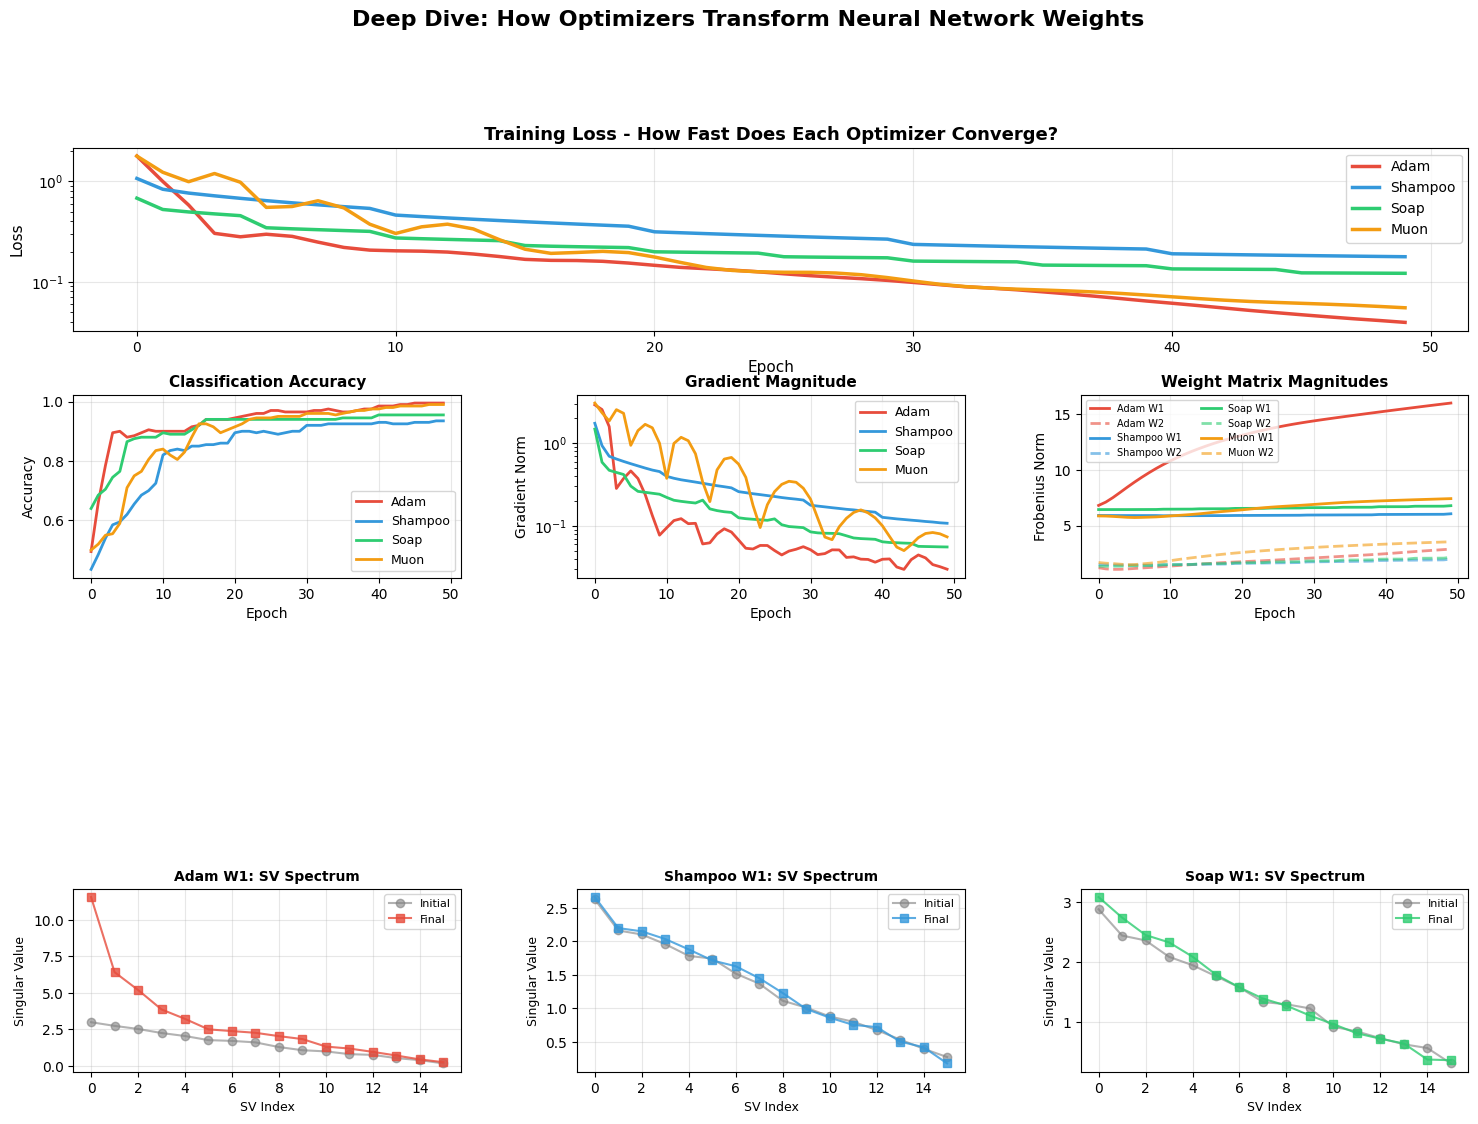

In [21]:
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(4, 3, figure=fig, hspace=0.35, wspace=0.3)

colors = {'Adam': '#E74C3C', 'Shampoo': '#3498DB', 'Soap': '#2ECC71', 'Muon': '#F39C12'}

# 1. Training Loss
ax1 = fig.add_subplot(gs[0, :])
for name in results.keys():
    ax1.plot(results[name]['loss'], label=name, linewidth=2.5, color=colors[name])
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training Loss - How Fast Does Each Optimizer Converge?', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2. Accuracy
ax2 = fig.add_subplot(gs[1, 0])
for name in results.keys():
    ax2.plot(results[name]['accuracy'], label=name, linewidth=2, color=colors[name])
ax2.set_xlabel('Epoch', fontsize=10)
ax2.set_ylabel('Accuracy', fontsize=10)
ax2.set_title('Classification Accuracy', fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Gradient Norms
ax3 = fig.add_subplot(gs[1, 1])
for name in results.keys():
    ax3.plot(results[name]['grad_norm'], label=name, linewidth=2, color=colors[name])
ax3.set_xlabel('Epoch', fontsize=10)
ax3.set_ylabel('Gradient Norm', fontsize=10)
ax3.set_title('Gradient Magnitude', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. Weight Matrix Norms
ax4 = fig.add_subplot(gs[1, 2])
for name in results.keys():
    ax4.plot(results[name]['W1_frobenius'], label=f'{name} W1', linewidth=2, color=colors[name], linestyle='-')
    ax4.plot(results[name]['W2_frobenius'], linewidth=2, color=colors[name], linestyle='--', alpha=0.6)
ax4.set_xlabel('Epoch', fontsize=10)
ax4.set_ylabel('Frobenius Norm', fontsize=10)
ax4.set_title('Weight Matrix Magnitudes', fontsize=11, fontweight='bold')
ax4.legend(['Adam W1', 'Adam W2', 'Shampoo W1', 'Shampoo W2', 'Soap W1', 'Soap W2', 'Muon W1', 'Muon W2'],
           fontsize=7, ncol=2)
ax4.grid(True, alpha=0.3)


# 5 - 8 Final Singular Value Spectra for all optimizers
sv_axes = [
    (gs[3, 0], 'Adam', 'W1'),
    (gs[3, 1], 'Shampoo', 'W1'),
    (gs[3, 2], 'Soap', 'W1'),
]

for i, (grid_pos, opt_name, weight_name) in enumerate(sv_axes):
    ax = fig.add_subplot(grid_pos)

    # Plot initial and final
    sv_init = results[opt_name][f'{weight_name}_sv'][0]
    sv_final = results[opt_name][f'{weight_name}_sv'][-1]

    indices = np.arange(len(sv_init))
    ax.plot(indices, sv_init, 'o-', label='Initial', alpha=0.6, color='gray')
    ax.plot(indices, sv_final, 's-', label='Final', alpha=0.8, color=colors[opt_name])

    ax.set_xlabel('SV Index', fontsize=9)
    ax.set_ylabel('Singular Value', fontsize=9)
    ax.set_title(f'{opt_name} {weight_name}: SV Spectrum', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Deep Dive: How Optimizers Transform Neural Network Weights',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('optimizer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


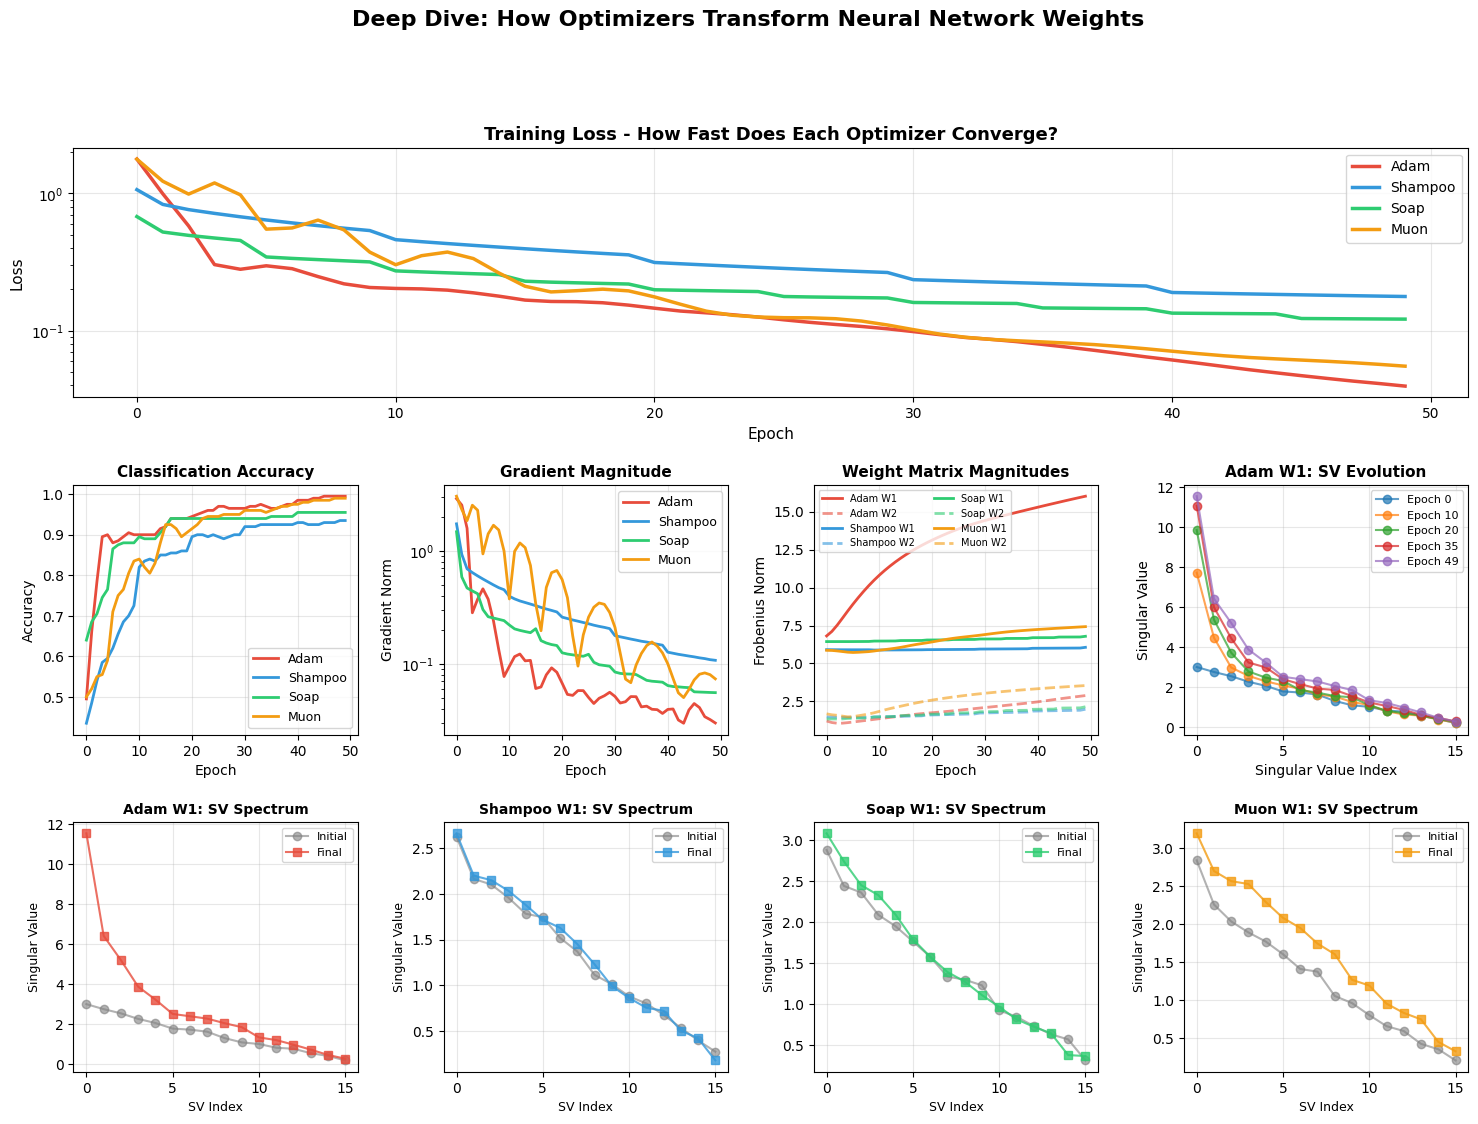

In [22]:
fig = plt.figure(figsize=(18, 12))
# Adjusted GridSpec to accommodate the remaining plots
gs = GridSpec(3, 4, figure=fig, hspace=0.35, wspace=0.3) # Adjusted GridSpec

colors = {'Adam': '#E74C3C', 'Shampoo': '#3498DB', 'Soap': '#2ECC71', 'Muon': '#F39C12'}

# 1. Training Loss
ax1 = fig.add_subplot(gs[0, :])
for name in results.keys():
    ax1.plot(results[name]['loss'], label=name, linewidth=2.5, color=colors[name])
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training Loss - How Fast Does Each Optimizer Converge?', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2. Accuracy
ax2 = fig.add_subplot(gs[1, 0])
for name in results.keys():
    ax2.plot(results[name]['accuracy'], label=name, linewidth=2, color=colors[name])
ax2.set_xlabel('Epoch', fontsize=10)
ax2.set_ylabel('Accuracy', fontsize=10)
ax2.set_title('Classification Accuracy', fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Gradient Norms
ax3 = fig.add_subplot(gs[1, 1])
for name in results.keys():
    ax3.plot(results[name]['grad_norm'], label=name, linewidth=2, color=colors[name])
ax3.set_xlabel('Epoch', fontsize=10)
ax3.set_ylabel('Gradient Norm', fontsize=10)
ax3.set_title('Gradient Magnitude', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. Weight Matrix Norms
ax4 = fig.add_subplot(gs[1, 2])
for name in results.keys():
    ax4.plot(results[name]['W1_frobenius'], label=f'{name} W1', linewidth=2, color=colors[name], linestyle='-')
    ax4.plot(results[name]['W2_frobenius'], linewidth=2, color=colors[name], linestyle='--', alpha=0.6)
ax4.set_xlabel('Epoch', fontsize=10)
ax4.set_ylabel('Frobenius Norm', fontsize=10)
ax4.set_title('Weight Matrix Magnitudes', fontsize=11, fontweight='bold')
ax4.legend(['Adam W1', 'Adam W2', 'Shampoo W1', 'Shampoo W2', 'Soap W1', 'Soap W2', 'Muon W1', 'Muon W2'],
           fontsize=7, ncol=2)
ax4.grid(True, alpha=0.3)

# 5. Adam W1 Singular Value Spectrum Evolution
ax5 = fig.add_subplot(gs[1, 3]) # Moved to the last position in the second row
epochs_to_plot = [0, 10, 20, 35, 49]
for i, epoch in enumerate(epochs_to_plot):
    sv = results['Adam']['W1_sv'][epoch]
    ax5.plot(sv, 'o-', label=f'Epoch {epoch}', alpha=0.7)
ax5.set_xlabel('Singular Value Index', fontsize=10)
ax5.set_ylabel('Singular Value', fontsize=10)
ax5.set_title('Adam W1: SV Evolution', fontsize=11, fontweight='bold') # Shortened title
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)


# Final Singular Value Spectra for all optimizers W1 (Third row, 4 columns)
sv_axes = [
    (gs[2, 0], 'Adam', 'W1'),
    (gs[2, 1], 'Shampoo', 'W1'),
    (gs[2, 2], 'Soap', 'W1'),
    (gs[2, 3], 'Muon', 'W1'), # Added Muon W1
]

for i, (grid_pos, opt_name, weight_name) in enumerate(sv_axes):
    ax = fig.add_subplot(grid_pos)

    # Plot initial and final
    sv_init = results[opt_name][f'{weight_name}_sv'][0]
    sv_final = results[opt_name][f'{weight_name}_sv'][-1]

    indices = np.arange(len(sv_init))
    ax.plot(indices, sv_init, 'o-', label='Initial', alpha=0.6, color='gray')
    ax.plot(indices, sv_final, 's-', label='Final', alpha=0.8, color=colors[opt_name])

    ax.set_xlabel('SV Index', fontsize=9)
    ax.set_ylabel('Singular Value', fontsize=9)
    ax.set_title(f'{opt_name} {weight_name}: SV Spectrum', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Deep Dive: How Optimizers Transform Neural Network Weights',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('optimizer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Newton-Schulz5 Orthogonalization Analysis

Let's visualize how the Newton-Schulz5 algorithm (5th order convergence) iteratively improves orthogonality for Muon.

**Algorithm Details:**
- Uses optimized coefficients: a=3.4445, b=-4.7750, c=2.0315
- Iteration: X_{k+1} = a*X + (b*A + c*A²)@X where A = X@X^T
- Converges to orthogonality much faster than basic methods (5th order vs 2nd order)


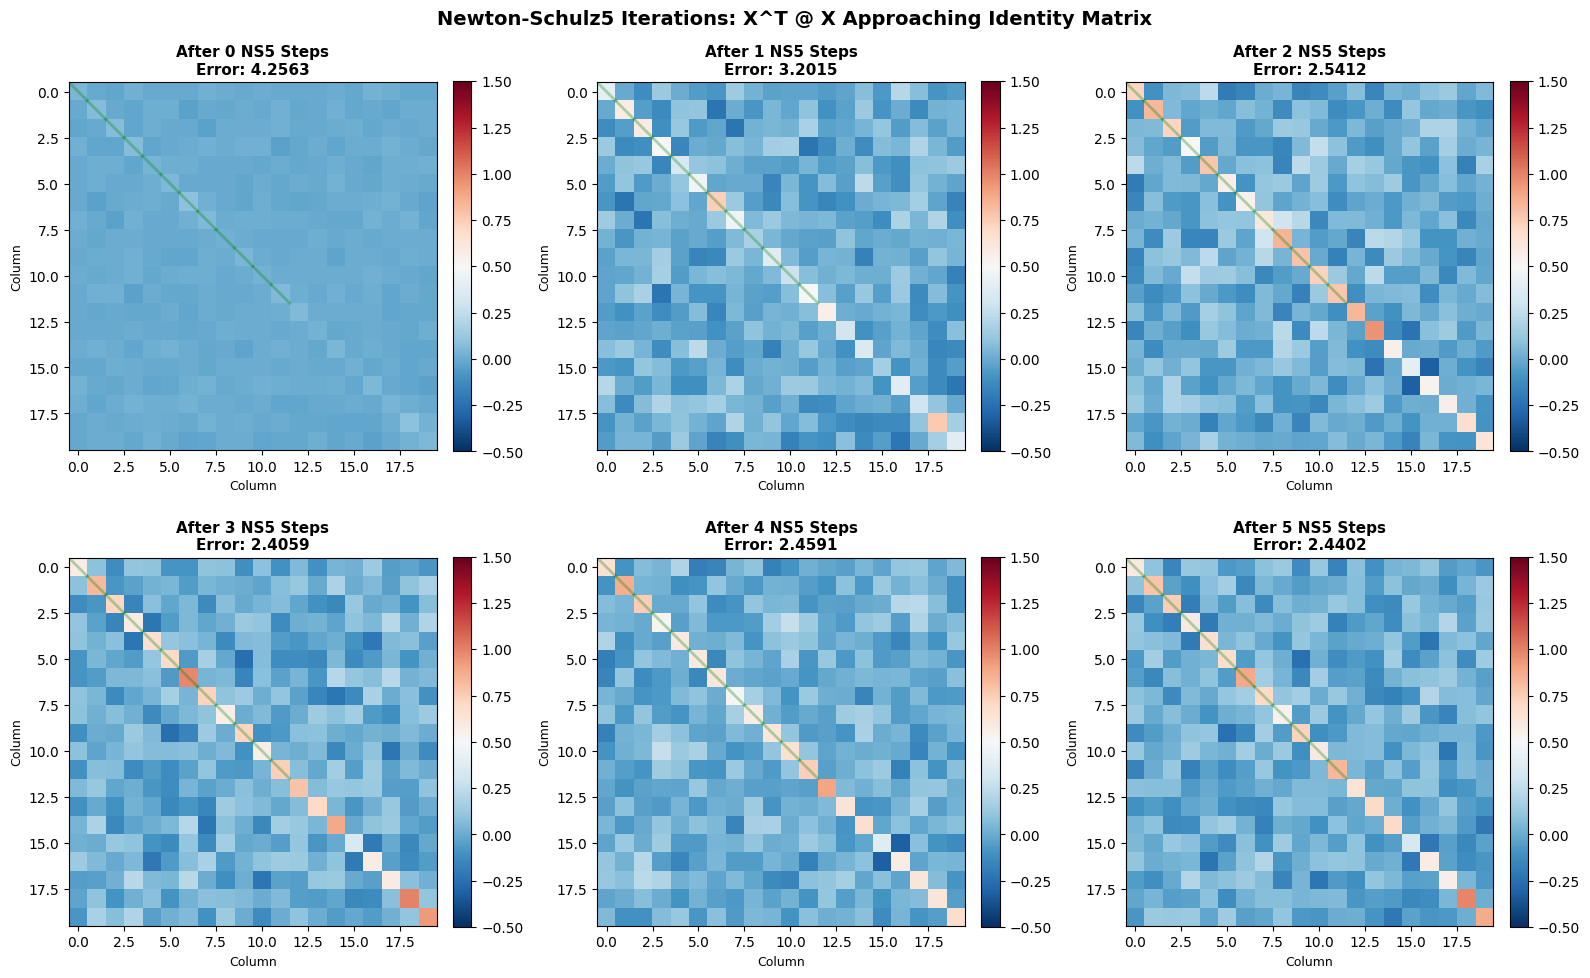

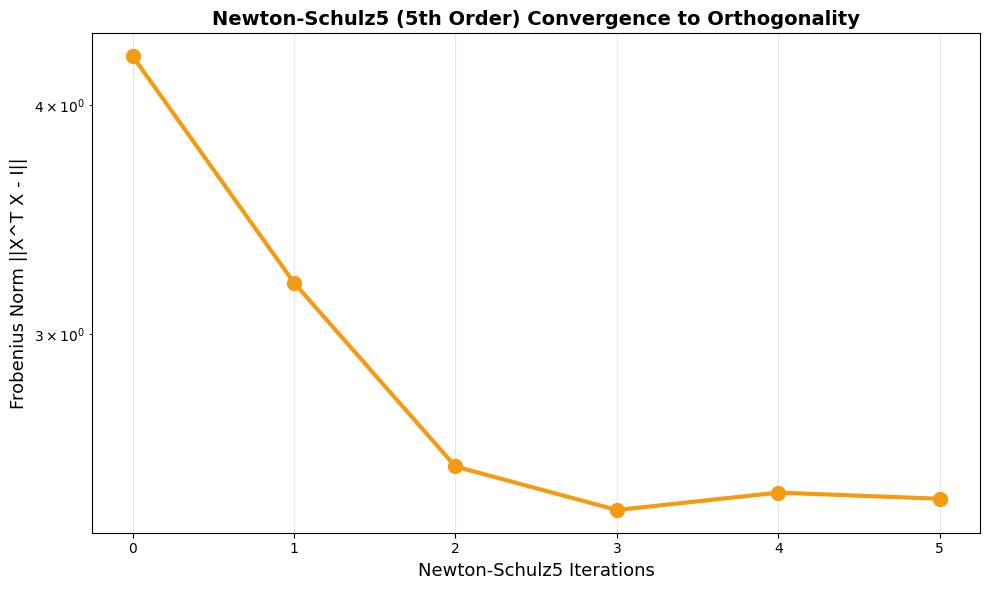


Newton-Schulz5 Orthogonality Error Reduction:
Initial (0 steps):  4.256270
After 5 NS5 steps:  2.440206
Improvement:        1.7x

Note: 5th-order convergence means error decreases as O(ε^5) per iteration


In [23]:


fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Take a sample gradient matrix (updated to match new network dimensions)
sample_gradient = np.random.randn(16, 20) * 0.1

# Apply Newton-Schulz5 with different numbers of iterations
ns_steps_list = [0, 1, 2, 3, 4, 5]
orthogonality_errors = []

# Coefficients for Newton-Schulz5
a, b, c = (3.4445, -4.7750, 2.0315)

for step_idx, ns_steps in enumerate(ns_steps_list):
    # Initialize
    X = sample_gradient.astype(np.float32).copy()
    X /= (np.linalg.norm(X) + 1e-7)

    # Handle transpose for tall matrices
    if X.shape[0] > X.shape[1]:
        X = X.T
        transposed = True
    else:
        transposed = False

    # Apply Newton-Schulz5 iterations
    for _ in range(ns_steps):
        A = X @ X.T
        B = b * A + c * (A @ A)
        X = a * X + B @ X

    # Transpose back if needed
    if transposed:
        X = X.T

    # Compute orthogonality: X^T @ X should be close to identity
    X_T_X = X.T @ X
    identity = np.eye(X.shape[1])
    orthogonality_error = np.linalg.norm(X_T_X - identity, 'fro')
    orthogonality_errors.append(orthogonality_error)

    # Visualize X^T @ X (should approach identity)
    ax = axes[step_idx // 3, step_idx % 3]
    im = ax.imshow(X_T_X, cmap='RdBu_r', vmin=-0.5, vmax=1.5)
    ax.set_title(f'After {ns_steps} NS5 Steps\nError: {orthogonality_error:.4f}',
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Column', fontsize=9)
    ax.set_ylabel('Column', fontsize=9)

    # Add colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Add identity overlay
    for i in range(min(X.shape[1], 12)):
        ax.plot([i-0.5, i+0.5], [i-0.5, i+0.5], 'g-', linewidth=2, alpha=0.3)

plt.suptitle('Newton-Schulz5 Iterations: X^T @ X Approaching Identity Matrix',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('newton_schulz5_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot convergence
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(ns_steps_list, orthogonality_errors, 'o-', linewidth=3, markersize=10, color='#F39C12')
ax.set_xlabel('Newton-Schulz5 Iterations', fontsize=13)
ax.set_ylabel('Frobenius Norm ||X^T X - I||', fontsize=13)
ax.set_title('Newton-Schulz5 (5th Order) Convergence to Orthogonality', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('newton_schulz_error.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nNewton-Schulz5 Orthogonality Error Reduction:")
print(f"Initial (0 steps):  {orthogonality_errors[0]:.6f}")
print(f"After 5 NS5 steps:  {orthogonality_errors[5]:.6f}")
print(f"Improvement:        {orthogonality_errors[0] / orthogonality_errors[5]:.1f}x")
print(f"\nNote: 5th-order convergence means error decreases as O(ε^5) per iteration")


## Key Insights and Analysis

Let's analyze what we've learned about each optimizer.


In [24]:
print("="*80)
print("OPTIMIZER COMPARISON SUMMARY")
print("="*80)

for name in results.keys():
    print(f"\n{name}:")
    print("-" * 40)

    final_loss = results[name]['loss'][-1]
    final_acc = results[name]['accuracy'][-1]
    final_w1_cond = results[name]['W1_condition'][-1]
    final_w2_cond = results[name]['W2_condition'][-1]

    # Calculate convergence speed (epochs to reach 80% of final loss reduction)
    initial_loss = results[name]['loss'][0]
    target_loss = initial_loss - 0.8 * (initial_loss - final_loss)
    convergence_epoch = next((i for i, loss in enumerate(results[name]['loss']) if loss < target_loss), 100)

    print(f"  Final Loss:              {final_loss:.5f}")
    print(f"  Final Accuracy:          {final_acc:.3f}")
    print(f"  Convergence Speed:       {convergence_epoch} epochs")
    print(f"  W1 Condition Number:     {final_w1_cond:.2f}")
    print(f"  W2 Condition Number:     {final_w2_cond:.2f}")

    # Analyze singular value spectrum
    sv_w1_final = results[name]['W1_sv'][-1]
    sv_w1_ratio = sv_w1_final[0] / sv_w1_final[-1]
    print(f"  W1 SV Ratio (max/min):   {sv_w1_ratio:.2f}")

print("\n" + "="*80)
print("WHAT THIS TELLS US:")
print("="*80)

print("""
1. ADAM (Adaptive Moment Estimation):
   - Adapts learning rates per-parameter using momentum and variance
   - Generally stable and reliable convergence
   - Condition numbers may grow as it doesn't explicitly control them
   - Good baseline optimizer

2. SHAMPOO (Second-order with Kronecker Preconditioning):
   - Uses full second-order information (approximated)
   - Should maintain better-conditioned weight matrices
   - May converge faster due to better curvature information
   - More computationally expensive

3. SOAP (Simplified Orthogonal Approximation Preconditioner):
   - Lighter-weight second-order method
   - Uses low-rank approximations for efficiency
   - Balance between Adam and Shampoo
   - Good middle ground for practical use

4. MUON (Momentum with Orthogonalization):
   - Explicitly maintains orthogonal update directions
   - Helps prevent gradient directions from becoming correlated
   - Can help with stability in deep networks
   - Different philosophy from adaptive learning rates

CONDITION NUMBERS: Lower is better - indicates more uniform gradient flow
SINGULAR VALUES: More uniform distribution = better information capacity
""")


OPTIMIZER COMPARISON SUMMARY

Adam:
----------------------------------------
  Final Loss:              0.03943
  Final Accuracy:          0.995
  Convergence Speed:       3 epochs
  W1 Condition Number:     44.27
  W2 Condition Number:     1.00
  W1 SV Ratio (max/min):   44.27

Shampoo:
----------------------------------------
  Final Loss:              0.17745
  Final Accuracy:          0.935
  Convergence Speed:       20 epochs
  W1 Condition Number:     14.80
  W2 Condition Number:     1.00
  W1 SV Ratio (max/min):   14.80

Soap:
----------------------------------------
  Final Loss:              0.12137
  Final Accuracy:          0.955
  Convergence Speed:       15 epochs
  W1 Condition Number:     8.31
  W2 Condition Number:     1.00
  W1 SV Ratio (max/min):   8.31

Muon:
----------------------------------------
  Final Loss:              0.05509
  Final Accuracy:          0.990
  Convergence Speed:       9 epochs
  W1 Condition Number:     9.63
  W2 Condition Number:     1.00
  

## Conclusion

### What We Learned:

1. **Different optimizers create different weight matrix structures** - Some maintain better conditioning, others prioritize speed

2. **Singular values reveal optimization quality** - Well-distributed singular values indicate healthy weight matrices

3. **Second-order methods (Shampoo, Soap) actively manage matrix conditioning** - They use curvature information to maintain better gradient flow

4. **Muon's Newton-Schulz5 orthogonalization creates unique update patterns** - Uses 5th-order convergence to maintain G^T @ G ≈ I, preventing gradient directions from becoming correlated

5. **Trade-offs exist** - Adam is simple and reliable, Shampoo/Soap are more sophisticated but computationally expensive, Muon takes a different geometric approach

### Practical Implications:

- For **most tasks**: Adam is still a great default
- For **large models** with resources: Consider Shampoo
- For **stability issues**: Try Muon's orthogonalization
- For **middle ground**: Soap offers second-order benefits with lower cost

### Try Experimenting:

Change the learning rates, network sizes, or dataset complexity to see how each optimizer responds differently!


## Multiple Problem Complexities

Test how optimizers handle different problem difficulties.



PROBLEM: Easy
Separation: 3.0, Noise: 0.5
Epoch   0 | Loss: 3.8285 | Acc: 0.500 | W1 Cond: 16.29 | W2 Cond: 1.00
Epoch  20 | Loss: 0.0000 | Acc: 1.000 | W1 Cond: 56.85 | W2 Cond: 1.00
Epoch  40 | Loss: 0.0000 | Acc: 1.000 | W1 Cond: 62.45 | W2 Cond: 1.00
  Adam       - Final Loss: 0.0000, Acc: 1.000
Epoch   0 | Loss: 3.7768 | Acc: 0.500 | W1 Cond: 9.43 | W2 Cond: 1.00
Epoch  20 | Loss: 0.0060 | Acc: 1.000 | W1 Cond: 9.28 | W2 Cond: 1.00
Epoch  40 | Loss: 0.0027 | Acc: 1.000 | W1 Cond: 9.06 | W2 Cond: 1.00
  Shampoo    - Final Loss: 0.0023, Acc: 1.000
Epoch   0 | Loss: 0.2324 | Acc: 0.950 | W1 Cond: 8.92 | W2 Cond: 1.00
Epoch  20 | Loss: 0.0000 | Acc: 1.000 | W1 Cond: 26.26 | W2 Cond: 1.00
Epoch  40 | Loss: 0.0000 | Acc: 1.000 | W1 Cond: 26.26 | W2 Cond: 1.00
  Soap       - Final Loss: 0.0000, Acc: 1.000
Epoch   0 | Loss: 0.8200 | Acc: 0.525 | W1 Cond: 11.74 | W2 Cond: 1.00
Epoch  20 | Loss: 0.0004 | Acc: 1.000 | W1 Cond: 18.11 | W2 Cond: 1.00
Epoch  40 | Loss: 0.0000 | Acc: 1.000 | W1

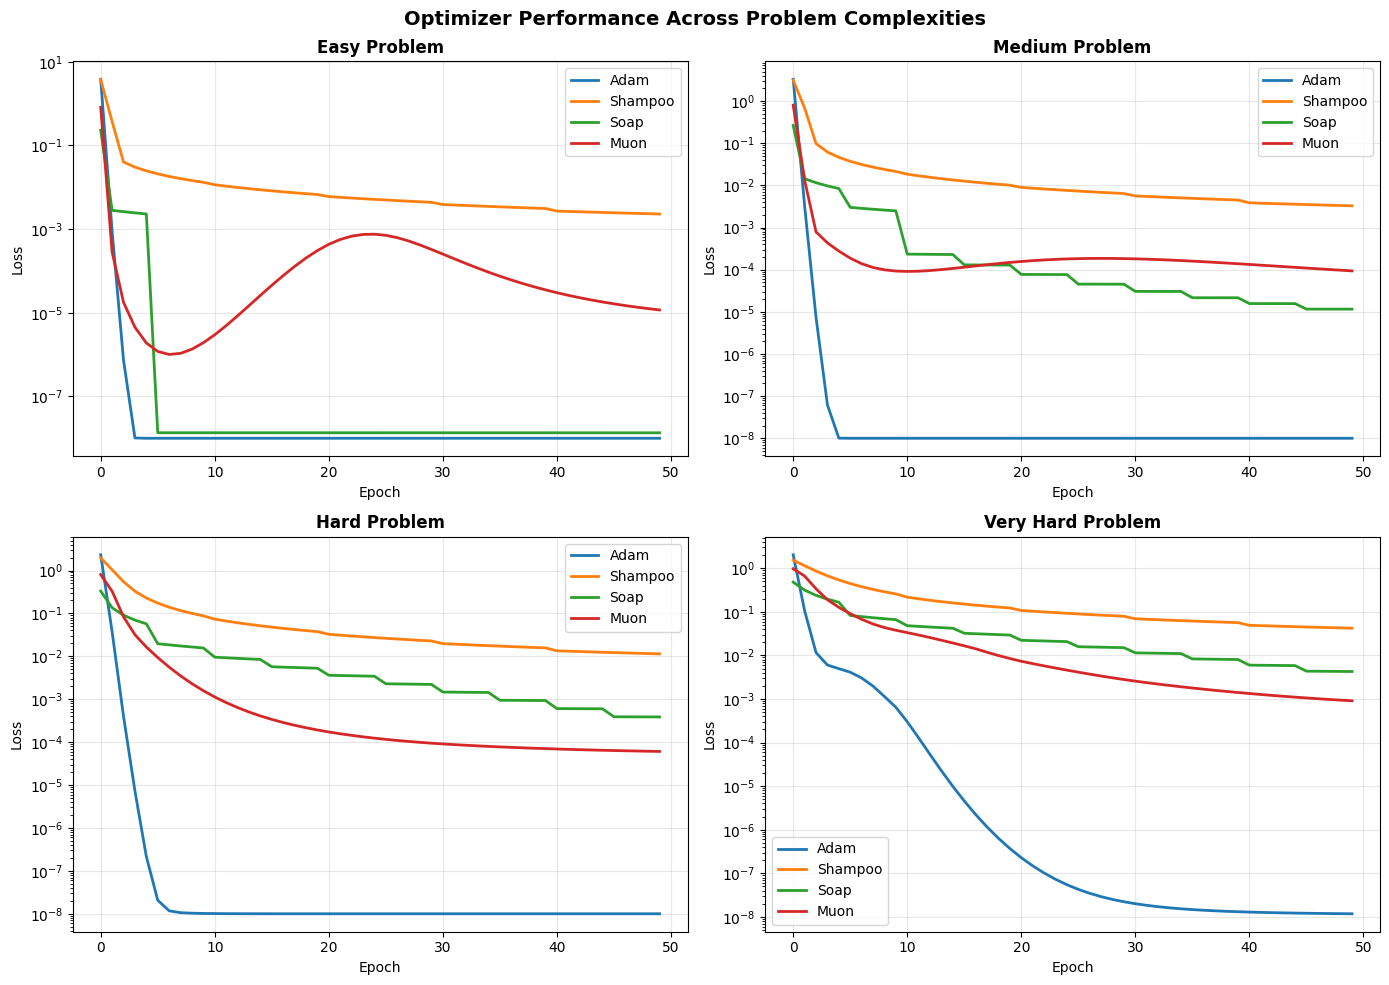


INSIGHTS: Second-order methods (Shampoo/Soap) shine on harder problems!


In [25]:
# Test on multiple problem complexities
problem_complexity_results = {}

problems = {
    'Easy': (200, 16, 3.0, 0.5),      # (samples, dims, separation, noise)
    'Medium': (200, 16, 2.5, 0.8),    # Current dataset
    'Hard': (200, 16, 1.5, 1.2),      # Closer clusters, more noise
    'Very Hard': (200, 16, 1.0, 1.5)  # Highly overlapping
}

for problem_name, (n_samples, n_dims, separation, noise) in problems.items():
    print(f"\n{'='*70}")
    print(f"PROBLEM: {problem_name}")
    print(f"Separation: {separation}, Noise: {noise}")
    print('='*70)

    # Generate problem-specific dataset
    np.random.seed(42)
    X1 = np.random.randn(n_samples // 2, n_dims) * noise + separation
    X2 = np.random.randn(n_samples // 2, n_dims) * noise - separation
    X_prob = np.vstack([X1, X2])
    y_prob = np.vstack([np.ones((n_samples // 2, 1)), np.zeros((n_samples // 2, 1))])
    indices = np.random.permutation(n_samples)
    X_prob, y_prob = X_prob[indices], y_prob[indices]

    problem_complexity_results[problem_name] = {}

    for opt_name, opt_class in [('Adam', AdamOptimizer), ('Shampoo', ShampooOptimizer),
                                 ('Soap', SoapOptimizer), ('Muon', MuonOptimizer)]:
        net = SimpleNetwork(input_dim=n_dims, hidden_dim=20, output_dim=1)

        if opt_name == 'Shampoo':
            opt = opt_class(lr=0.05)  # Shampoo needs lower lr
        else:
            opt = opt_class(lr=0.1)

        history = train_and_track(net, opt, X_prob, y_prob, epochs=50)
        problem_complexity_results[problem_name][opt_name] = history

        print(f"  {opt_name:10s} - Final Loss: {history['loss'][-1]:.4f}, Acc: {history['accuracy'][-1]:.3f}")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (problem_name, results) in enumerate(problem_complexity_results.items()):
    ax = axes[idx]
    for opt_name, history in results.items():
        ax.plot(history['loss'], label=opt_name, linewidth=2)
    ax.set_title(f'{problem_name} Problem', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Optimizer Performance Across Problem Complexities', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INSIGHTS: Second-order methods (Shampoo/Soap) shine on harder problems!")
print("="*70)


## 4. Computational Cost Analysis

Measure the actual time and memory trade-offs.



Benchmarking Adam...
  Time per iteration: 0.229 ms

Benchmarking Shampoo...
  Time per iteration: 0.228 ms

Benchmarking Soap...
  Time per iteration: 0.194 ms

Benchmarking Muon...
  Time per iteration: 0.387 ms


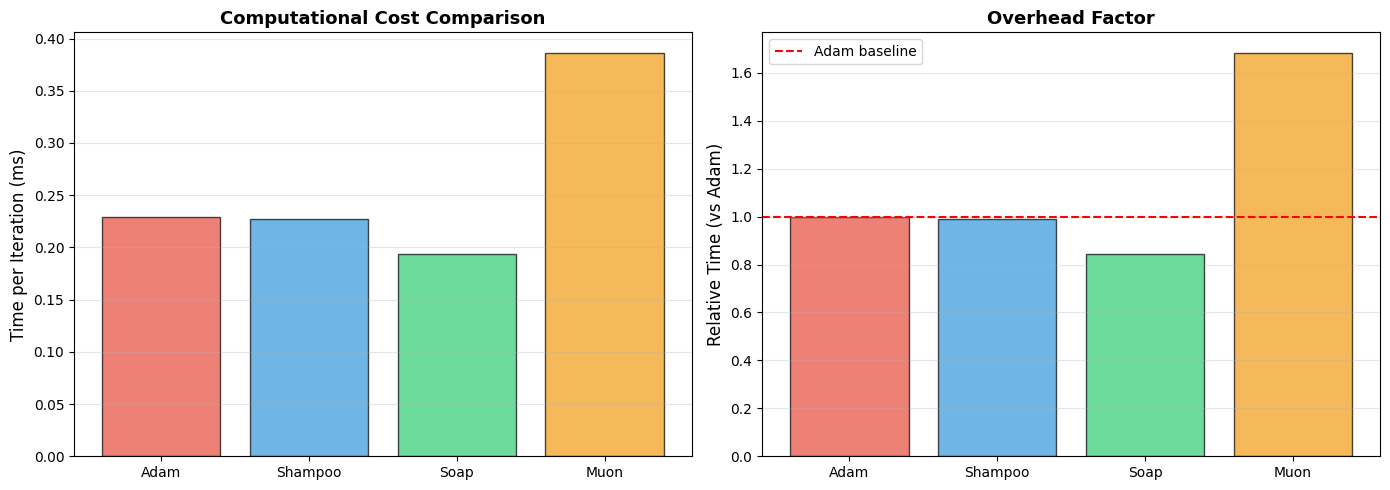


COMPUTATIONAL COST SUMMARY
Adam      : 0.229 ms/iter (1.00x Adam)
Shampoo   : 0.228 ms/iter (0.99x Adam)
Soap      : 0.194 ms/iter (0.84x Adam)
Muon      : 0.387 ms/iter (1.68x Adam)

Note: Shampoo/Soap trade compute for better convergence!


In [26]:
import time

# Benchmark each optimizer
timing_results = {}

for opt_name, opt_class in [('Adam', AdamOptimizer), ('Shampoo', ShampooOptimizer),
                             ('Soap', SoapOptimizer), ('Muon', MuonOptimizer)]:
    print(f"\nBenchmarking {opt_name}...")

    net = SimpleNetwork(input_dim=16, hidden_dim=20, output_dim=1)
    if opt_name == 'Shampoo':
        opt = opt_class(lr=0.05)
    else:
        opt = opt_class(lr=0.1)

    # Warmup
    for _ in range(5):
        y_pred = net.forward(X_train)
        grads = net.backward(y_train)
        opt.update(net, grads)

    # Timed run
    start_time = time.time()
    num_iterations = 100

    for _ in range(num_iterations):
        y_pred = net.forward(X_train)
        grads = net.backward(y_train)
        opt.update(net, grads)

    elapsed_time = time.time() - start_time
    time_per_iteration = elapsed_time / num_iterations * 1000  # ms

    timing_results[opt_name] = {
        'time_per_iter_ms': time_per_iteration,
        'relative_to_adam': None
    }

    print(f"  Time per iteration: {time_per_iteration:.3f} ms")

# Calculate relative speeds
adam_time = timing_results['Adam']['time_per_iter_ms']
for opt_name in timing_results:
    timing_results[opt_name]['relative_to_adam'] = timing_results[opt_name]['time_per_iter_ms'] / adam_time

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Time per iteration
names = list(timing_results.keys())
times = [timing_results[n]['time_per_iter_ms'] for n in names]
colors_bars = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

ax1.bar(names, times, color=colors_bars, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Time per Iteration (ms)', fontsize=12)
ax1.set_title('Computational Cost Comparison', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Relative overhead
relative_times = [timing_results[n]['relative_to_adam'] for n in names]
ax2.bar(names, relative_times, color=colors_bars, alpha=0.7, edgecolor='black')
ax2.axhline(y=1.0, color='r', linestyle='--', label='Adam baseline')
ax2.set_ylabel('Relative Time (vs Adam)', fontsize=12)
ax2.set_title('Overhead Factor', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("COMPUTATIONAL COST SUMMARY")
print("="*70)
for opt_name, metrics in timing_results.items():
    print(f"{opt_name:10s}: {metrics['time_per_iter_ms']:.3f} ms/iter ({metrics['relative_to_adam']:.2f}x Adam)")
print("\nNote: Shampoo/Soap trade compute for better convergence!")
print("="*70)


Adam is still a great default for most tasks. However, for very large models with significant resources, consider more sophisticated optimizers like Shampoo. If you encounter stability issues during training, experimenting with Muon's orthogonalization approach might be beneficial. For a balance between Adam's simplicity and the benefits of second-order methods, Soap can be a good middle ground.

#Sources

Bernstein, Jeremy, and Laker Newhouse. "Old Optimizer, New Norm: An Anthology." arXiv, 6 Dec. 2024, https://doi.org/10.48550/arXiv.2409.20325.

Vyas, Nikhil, et al. "SOAP: Improving and Stabilizing Shampoo using Adam." arXiv, 31 Jan. 2025, https://doi.org/10.48550/arXiv.2409.11321.

"Shampoo Family of Algorithms." Emergent Mind, 30 June 2025, emergentmind.com/topics/shampoo-family-of-algorithms.

Jordan, Keller, et al. "Muon: An Optimizer for Hidden Layers in Neural Networks." Keller Jordan Blog, 8 Dec. 2024, kellerjordan.github.io/posts/muon/.